# Demonstrate impact of surface chemistry variations on CO<sub>2</sub> uptake efficiency

In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
from functools import partial

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cmocean

import co2calc
import glodap

## Load the GLODAP dataset 

[GLODAP](https://www.glodap.info/) is a observational synthesis of biogeochemical variables over the global ocean.

The `glodap` module provides an interface to these data.


In [3]:
ds = glodap.open_glodap(product='GLODAPv2.2016b_MappedClimatologies')

# subset for surface
ds = ds.isel(depth=0, drop=True)
ds

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, bnds: 2)
Coordinates:
  * lon           (lon) float64 20.5 21.5 22.5 23.5 ... 376.5 377.5 378.5 379.5
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables: (12/17)
    Cant          (lat, lon) float64 ...
    NO3           (lat, lon) float64 ...
    OmegaA        (lat, lon) float64 ...
    OmegaC        (lat, lon) float64 ...
    PI_TCO2       (lat, lon) float64 ...
    PO4           (lat, lon) float64 ...
    ...            ...
    SALT          (lat, lon) float64 ...
    SiO3          (lat, lon) float64 ...
    TEMP          (lat, lon) float64 ...
    area          (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08
    depth_bnds    (bnds) float64 -5.0 5.0
    dz            float64 10.0
Attributes:
    Description:          1 X 1 global mapped field of anthropogenic carbon c...
    Created:              Created by Siv K. Lauvset on 12-May-2016 18:48:16
    Institution name:     University of Bergen
    Contact information:  siv.lauvset@uib.no; are.olsen@uib.no
    Citation:             Cite as: Lauvset, Siv K., Key, Robert M., Olsen, Ar...

## Illustrate CO<sub>2</sub> uptake efficiency

In [4]:
dic_bounds = np.nanpercentile(ds.DIC, [10, 90])
dic_bounds

array([1928.64620361, 2138.35637207])

In [5]:
alk_bounds = np.nanpercentile(ds.ALK, [10, 90])
alk_bounds

array([2203.33786621, 2365.49665527])

In [6]:
ds.SALT.weighted(ds.area).mean(['lat', 'lon']).values.item()

34.67791007821709

In [58]:
S_mean = ds.SALT.weighted(ds.area).mean(["lat", "lon"]).values.item()
T_mean = ds.TEMP.weighted(ds.area).mean(["lat", "lon"]).values.item()

PO4_mean = ds.PO4.weighted(ds.area).mean(["lat", "lon"]).values.item()
SiO3_mean = ds.SiO3.weighted(ds.area).mean(["lat", "lon"]).values.item()


# compute solubility
co2sol = co2calc.co2sol(S_mean, T_mean, return_in_gravimetric_units=True)

dic_axis = np.arange(1900, 2060, 20)
alk_axis = np.arange(2200, 2380, 20)

pCO2_phase_space = np.empty((len(dic_axis), len(alk_axis)))
pH_phase_space = np.empty((len(dic_axis), len(alk_axis)))

calc_co2 = partial(
    co2calc.calc_co2,
    S=S_mean,
    T=T_mean,
    PO4=PO4_mean,
    SiO3=SiO3_mean,
    input_in_gravimetric_units=True,
)
calc_pH = partial(
    co2calc.calc_pH_from_dic_alk,
    S=S_mean,
    T=T_mean,
    PO4=PO4_mean,
    SiO3=SiO3_mean,
    input_in_gravimetric_units=True,
)

calc_dic = partial(
    co2calc.calc_dic,
    S=S_mean,
    T=T_mean,
    PO4=PO4_mean,
    SiO3=SiO3_mean,
    input_in_gravimetric_units=True,
)

for i, dic in enumerate(dic_axis):
    for j, alk in enumerate(alk_axis):
        co2aq = calc_co2(dic, alk)
        pCO2_phase_space[i, j] = co2aq / co2sol / 1.0e-6

        pH = calc_pH(dic, alk)
        pH_phase_space[i, j] = pH


alk_start = 2250.0
pCO2_target = 300.0
alk_end = 2290.0

dic_start = calc_dic(alk_start, pCO2_target)
pH_start = calc_pH(dic_start, alk_start)

dic_end = calc_dic(alk_end, pCO2_target)
pH_end = calc_pH(dic_end, alk_end)


print(f'pH change: {pH_end - pH_start:0.4f}')

pH change: 0.0065


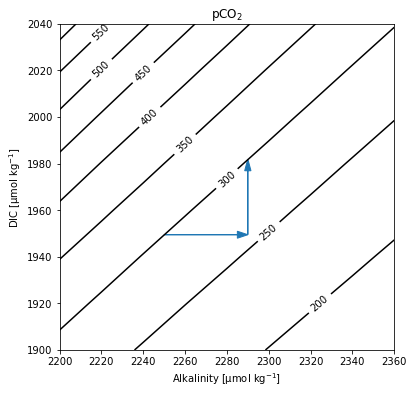

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(
    alk_axis,
    dic_axis,
    pCO2_phase_space,
    levels=np.arange(200, 2050, 50),
    colors='k',
)

head_length = 5
ax.arrow(
    alk_start,
    dic_start,
    alk_end - alk_start - head_length,
    0,
    head_width=3,
    head_length=head_length,
    color="tab:blue",
)
ax.arrow(
    alk_end,
    dic_start,
    0,
    dic_end - dic_start - head_length,
    head_width=3,
    head_length=head_length,
    color="tab:blue",
)


ax.clabel(cs, cs.levels, inline=True, fontsize=10)
ax.set_ylabel(f"DIC [{ds.DIC.attrs['units']}]")
ax.set_xlabel(f"Alkalinity [{ds.ALK.attrs['units']}]")
ax.set_title('pCO$_2$');

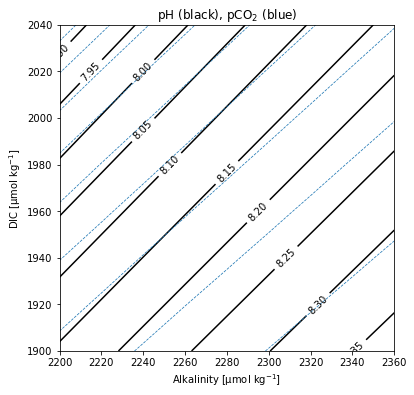

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(
    alk_axis,
    dic_axis,
    pH_phase_space,
    levels=np.arange(7.9, 8.4, 0.05),
    colors='k',
)
ax.clabel(cs, cs.levels, inline=True, fontsize=10)

cs = ax.contour(
    alk_axis,
    dic_axis,
    pCO2_phase_space,
    levels=np.arange(200, 2050, 50),
    colors='tab:blue',
    linestyles='--',
    linewidths=0.75,
)


ax.set_ylabel(f"DIC [{ds.DIC.attrs['units']}]")
ax.set_xlabel(f"Alkalinity [{ds.ALK.attrs['units']}]")

ax.set_title('pH (black), pCO$_2$ (blue)');

## Compute CO<sub>2</sub> uptake efficiency

In [36]:
co2aq = co2calc.calc_co2(
    S=ds.SALT,
    T=ds.TEMP,
    DIC=ds.DIC,
    ALK=ds.ALK,
    PO4=ds.PO4,
    SiO3=ds.SiO3,
    input_in_gravimetric_units=True,
)
co2sol = co2calc.co2sol(ds.SALT, ds.TEMP, return_in_gravimetric_units=True)

pCO2 = 1.0e6 * co2aq / co2sol

DALK = 1.0
DIC_pert_alk = co2calc.calc_dic(
    S=ds.SALT,
    T=ds.TEMP,
    ALK=ds.ALK + DALK,
    pCO2=pCO2,
    PO4=ds.PO4,
    SiO3=ds.SiO3,
    input_in_gravimetric_units=True,
)

dDIC_dALK = (DIC_pert_alk - ds.DIC) / DALK
dDIC_dALK.attrs['units'] = 'mol/mol'
dDIC_dALK

/glade/work/mclong/miniconda3/envs/_unison/lib/python3.7/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


<xarray.DataArray (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 20.5 21.5 22.5 23.5 24.5 ... 376.5 377.5 378.5 379.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    units:    mol/mol

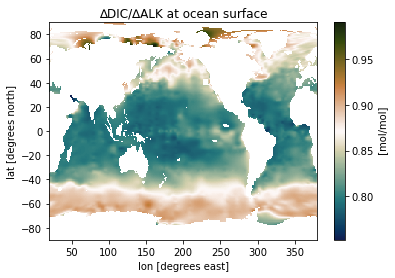

In [41]:
dDIC_dALK.plot(cmap=cmocean.cm.tarn_r)
plt.title('∆DIC/∆ALK at ocean surface');

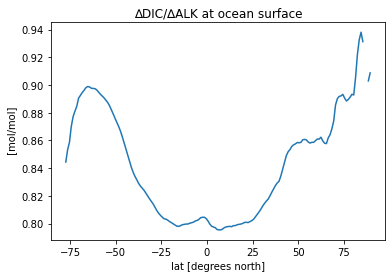

In [40]:
with xr.set_options(keep_attrs=True):
    dDIC_dALK.weighted(ds.area).mean('lon').plot();
plt.title('∆DIC/∆ALK at ocean surface');